## Project Description

The goal of this notebook is to build a Naive Bayes classifier to predict whether a song is happy or sad.

In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import math
from scipy import stats
from pandas import Int64Index
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split
import sklearn.naive_bayes
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score


C:\Users\tibyr\AppData\Local\Temp/ipykernel_7208/2393949790.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index


## Import data

In [147]:
random.seed(1026)

In [148]:
# import data set
data = pd.read_csv("278k_song_labelled.csv")

# filter for songs labelled happy or sad
data = data[data['labels'].isin([0,1])]

data.head(5)

,Unnamed: 0,duration (ms),danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,spec_rate,labels
1,1,194641.0,0.638,0.781,-6.848,0.0285,0.0118,0.009530,0.3490,0.250,122.985,1.464234e-07,1
2,2,217573.0,0.560,0.810,-8.029,0.0872,0.0071,0.000008,0.2410,0.247,170.044,4.007850e-07,1
3,3,443478.0,0.525,0.699,-4.571,0.0353,0.0178,0.000088,0.0888,0.199,92.011,7.959809e-08,0
4,4,225862.0,0.367,0.771,-5.863,0.1060,0.3650,0.000001,0.0965,0.163,115.917,4.693131e-07,1
5,5,166920.0,0.572,0.837,-7.876,0.0367,0.0197,0.000000,0.1630,0.627,100.343,2.198658e-07,1


In [149]:
data.shape

(188487, 13)

In [150]:
# reduce sample size for computational efficiency
df = data.head(10000)

In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 17101
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        10000 non-null  int64  
 1   duration (ms)     10000 non-null  float64
 2   danceability      10000 non-null  float64
 3   energy            10000 non-null  float64
 4   loudness          10000 non-null  float64
 5   speechiness       10000 non-null  float64
 6   acousticness      10000 non-null  float64
 7   instrumentalness  10000 non-null  float64
 8   liveness          10000 non-null  float64
 9   valence           10000 non-null  float64
 10  tempo             10000 non-null  float64
 11  spec_rate         10000 non-null  float64
 12  labels            10000 non-null  int64  
dtypes: float64(11), int64(2)
memory usage: 1.1 MB


Luckily we won't have to do any data cleanup since there aren't any nulls.

In [173]:
df.describe()

,Unnamed: 0,duration (ms),danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,spec_rate,labels
count,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000
mean,7595.820600,2.440999e+05,0.587954,0.607066,-8.729075,0.077972,0.279095,0.128623,0.187653,0.495131,119.971940,4.209814e-07,0.574800
std,5162.917782,1.190996e+05,0.169477,0.201545,3.719429,0.090477,0.286568,0.263438,0.157868,0.256015,27.603242,8.636734e-07,0.494398
min,1.000000,1.404000e+04,0.000000,0.002840,-42.416000,0.000000,0.000002,0.000000,0.013200,0.000000,0.000000,0.000000e+00,0.000000
25%,3157.750000,1.836000e+05,0.476000,0.472000,-10.660250,0.032500,0.039175,0.000000,0.095300,0.285000,98.077500,1.293705e-07,0.000000
50%,6756.500000,2.223200e+05,0.603000,0.630000,-8.078000,0.041300,0.163000,0.000231,0.123000,0.485000,119.947500,1.866806e-07,1.000000
75%,11540.250000,2.725715e+05,0.711000,0.758000,-6.141750,0.073225,0.463000,0.059200,0.227000,0.708000,137.377250,3.821710e-07,1.000000
max,17101.000000,3.600000e+06,0.983000,1.000000,1.424000,0.938000,0.996000,1.000000,0.990000,0.992000,217.591000,2.892774e-05,1.000000


## EDA

In [153]:
# define feature columns
features_col = ['duration (ms)', 'danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'spec_rate']

X = df[features_col]
# define target column
y = df['labels']

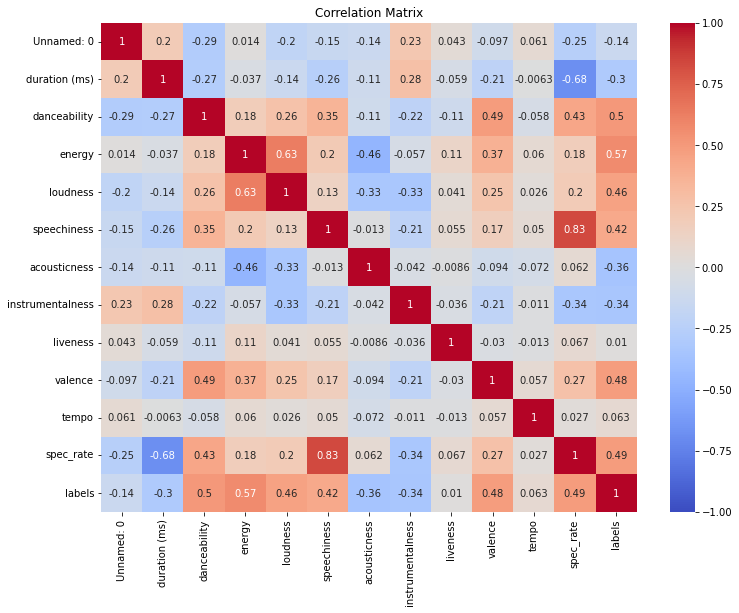

In [154]:
# create correlation matrix for features
correlation_matrix = df.corr(method='spearman')

plt.figure(figsize=(12, 9))

# plot heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

There is some correlation between spec_rate and speechiness. 

## Train & Test

### Split data

In [155]:
# split into training and test set - 70-30 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10)

In [156]:
X_train.shape, X_test.shape

((7000, 11), (3000, 11))

### Scale

In [157]:
# normalizes features to the range [0, 1]
scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=[features_col])
X_test = pd.DataFrame(scaler.transform(X_test),columns=[features_col])

### Gaussian Naive Bayes

In [158]:
# instantiate the model
gnb = sklearn.naive_bayes.GaussianNB()

# fit the model
gnb.fit(X_train, y_train)

# predict the results
y_pred_gnb = gnb.predict(X_test)

### Bernoulli Naive Bayes

In [159]:
# instantiate the model
bnb = sklearn.naive_bayes.BernoulliNB()

# fit the model
bnb.fit(X_train, y_train)

# predict the results
y_pred_bnb = bnb.predict(X_test)

### Multinomial Naive Bayes

In [160]:
# instantiate the model
mnb = sklearn.naive_bayes.MultinomialNB()

# fit the model
mnb.fit(X_train, y_train)

# predict the results
y_pred_mnb = mnb.predict(X_test)

In [161]:
# store predicted results
y_pred = [y_pred_gnb, y_pred_bnb, y_pred_mnb]

## Evaluation

### Accuracy

In [162]:
accuracy_scores = []
models = ['Gaussian','Bernoulli','Multinomial']

# calculate accuracy score fore each model
for i, pred in enumerate(y_pred):
    score = accuracy_score(y_test, pred)
    accuracy_scores.append(score)
    print(f'{models[i]}: {round(score,4)}')

Gaussian: 0.8553
Bernoulli: 0.5663
Multinomial: 0.768


### Null Accuracy

In [163]:
# check class distribution in test set
y_test.value_counts()

1    1759
0    1241
Name: labels, dtype: int64

'Happy' is the most frequent category. Calculate null accuracy by dividing count of 'happy' songs by the total.

In [164]:
null_accuracy = sum(y_test)/len(y_test)
print(f'Null Accuracy: {round(null_accuracy,4)}')

Null Accuracy: 0.5863


The Gaussian and Multinomial models have an accuracy score that is higher than the null accuracy, which means they predicted well. The Bernoulli score is about the same.

### Confusion matrix

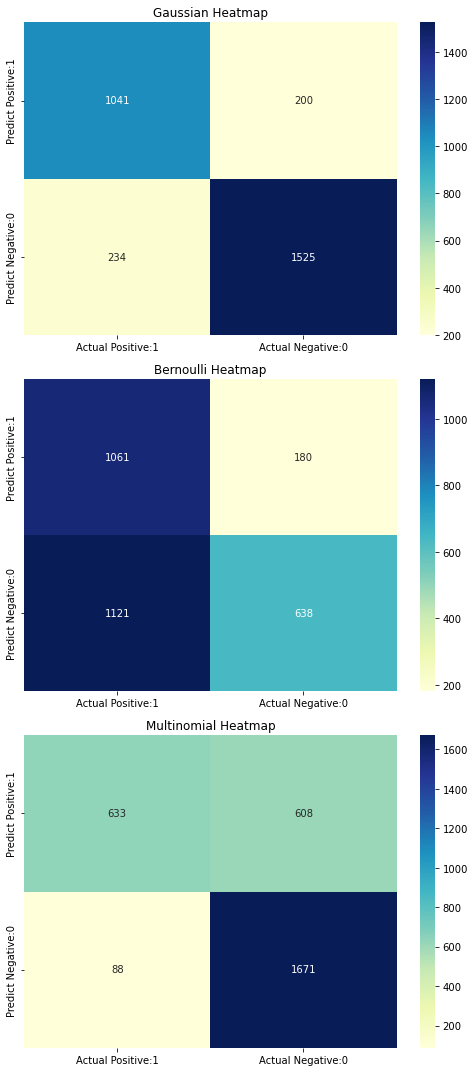

In [165]:
fig, axs = plt.subplots(3, 1, figsize=(7, 15))

# calculate accuracy score fore each model
for i, pred in enumerate(y_pred):
    # build confusion matrix
    cm = confusion_matrix(y_test, pred)

    # visualize confusion matrix with seaborn heatmap
    cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                             index=['Predict Positive:1', 'Predict Negative:0'])

    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu', ax=axs[i])
    axs[i].set_title(f'{models[i]} Heatmap')
    
# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

We can see that the Multinomial model had more false positives than the Gaussian - which corraborates the Gaussian's accuracy.

### Model Performance

In [171]:
# create classification report to evaluate model performance
for i, pred in enumerate(y_pred):
    print(f'{models[i]}:\n {classification_report(y_test, pred)}')

Gaussian:
               precision    recall  f1-score   support

           0       0.82      0.84      0.83      1241
           1       0.88      0.87      0.88      1759

    accuracy                           0.86      3000
   macro avg       0.85      0.85      0.85      3000
weighted avg       0.86      0.86      0.86      3000

Bernoulli:
               precision    recall  f1-score   support

           0       0.49      0.85      0.62      1241
           1       0.78      0.36      0.50      1759

    accuracy                           0.57      3000
   macro avg       0.63      0.61      0.56      3000
weighted avg       0.66      0.57      0.55      3000

Multinomial:
               precision    recall  f1-score   support

           0       0.88      0.51      0.65      1241
           1       0.73      0.95      0.83      1759

    accuracy                           0.77      3000
   macro avg       0.81      0.73      0.74      3000
weighted avg       0.79      0.77    

Precision = TP / (TP + FP) = percentage of correctly predicted positives out of true and false positives \
Recall (Sensitivity) = TP / (TP + FN) = percentage of correclty predicted positives out of actual positives \

### k-fold Cross Validation

In [167]:
cv_scores = []
models = ['Gaussian','Bernoulli','Multinomial']
model_bayes = [gnb, bnb, mnb]

# Apply 10-Fold Cross Validation for each model
for i, bayes in enumerate(model_bayes):
    scores = cross_val_score(bayes, X_train, y_train, cv = 10, scoring='accuracy')
    
    # calculate average cross-validation score
    avg_ck = scores.mean()
    cv_scores.append(avg_ck)
    
    # calculate sample variance
    var_ck = np.var(scores)
    
    print(f'{models[i]} Avg CV Score: {round(avg_ck,4)}; ', 
          f'{models[i]} Var CV Score: {round(var_ck,4)}')

Gaussian Avg CV Score: 0.8439;  Gaussian Var CV Score: 0.0001
Bernoulli Avg CV Score: 0.5739;  Bernoulli Var CV Score: 0.0002
Multinomial Avg CV Score: 0.7446;  Multinomial Var CV Score: 0.0001


The cross validation score shows how accurate the model is on average. The cross-validation score is about the same for the Gaussian as it is for the original. However, the ck-score is lower for the Bernoulli and Multinomial models, which suggests that on average they do not perform as well as the original.

In addition, the sample variance for the CV scores is fairly low which suggests that the scores are relatively consistent. 